## 6장 실습

In [1]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas as pd
np.set_printoptions(precision=4)

### 1) lxml 라이브러리를 이용한 웹 데이터 추출
6.1.5 절 1)에서 <a href=url>링크 문자열</a>의 구조를 갖는 Elements를 links로 생성하였다.
links로 부터 [(링크 문자열, active url), .... ]와 같은 구조를 갖는 pandas 데이터프레임 객체를 생성하라.

단, active url은 단순히 웹서버 내에서만 지정되는 상대 경로가 아닌, 사용자의 브라우저에서 직접 입력되어 브라우징이 가능한 url 이어야 한다.

>active url의 예: https://finance.yahoo.com/watchlists

In [30]:
url = 'https://finance.yahoo.com/quote/AAPL/options?ltr=1'

In [31]:
subs = url.split(sep='/')
subs

['https:', '', 'finance.yahoo.com', 'quote', 'AAPL', 'options?ltr=1']

In [32]:
page = '/'.join(subs[:3])
page

'https://finance.yahoo.com'

In [33]:
from lxml.html import parse
from urllib.request import urlopen

parsed = parse(urlopen(url))

doc = parsed.getroot()
links = doc.findall('.//a')

In [35]:
link = links[0]
link.text_content()
link.get('href')

'https://finance.yahoo.com/'

In [36]:
def _unpack(lnk):
    txt = lnk.text_content()
    remote = lnk.get('href')
    return [txt, remote]

In [44]:
_, remote = _unpack(links[2])
remote

'https://mail.yahoo.com/?.intl=us&.lang=en-US&.partner=none&.src=finance'

In [41]:
if remote[:4] == 'http':
    remote = remote
else:
    remote = page + remote
remote

'https://finance.yahoo.com/quote/AAPL/options?strike=150&straddle=false'

In [42]:
def createRemote(remote):
    if remote[:4] == 'http':
        remote = remote
    else:
        remote = page + remote
    return remote

In [45]:
createRemote(remote)

'https://mail.yahoo.com/?.intl=us&.lang=en-US&.partner=none&.src=finance'

In [46]:
def unpack(lnk):
    txt = lnk.text_content()
    remote = lnk.get('href')
    remote = createRemote(remote)
    return [txt, remote]

In [48]:
unpack(links[34])

['150.00',
 'https://finance.yahoo.com/quote/AAPL/options?strike=150&straddle=false']

In [49]:
from pandas.io.parsers import TextParser

def parse_options_data(doc):
    links = doc.findall('.//a')
    data = [unpack(lnk) for lnk in links]
    return TextParser(data, names=['contents', 'remote Page']).get_chunk()

In [50]:
parse_options_data(doc)

,contents,remote Page
0,Yahoo,https://finance.yahoo.com/
1,Give feedback on the new search experience,https://yahoo.uservoice.com/forums/439018
2,Mail,https://mail.yahoo.com/?.intl=us&.lang=en-US&....
3,Summary,https://finance.yahoo.com/quote/AAPL?p=AAPL
4,Statistics,https://finance.yahoo.com/quote/AAPL/key-stati...
5,Historical Data,https://finance.yahoo.com/quote/AAPL/history?p...
6,Profile,https://finance.yahoo.com/quote/AAPL/profile?p...
7,Financials,https://finance.yahoo.com/quote/AAPL/financial...
8,Analysis,https://finance.yahoo.com/quote/AAPL/analysis?...
9,Options,https://finance.yahoo.com/quote/AAPL/options?p...


### 2) Web APIs

In [143]:
import requests
url = 'https://api.github.com/repos/pandas-dev/pandas/issues'
resp = requests.get(url)
resp

<Response [200]>

In [150]:
data = resp.json()
issues = pd.DataFrame(data, columns=['number', 'title',
                                     'labels', 'state'])
issues

,number,title,labels,state
0,25831,Can't sort DataFrame when level=[] and sort_re...,[],open
1,25830,bug!!when `json_normalize` string has `null`,[],open
2,25829,#25790 Updating type hints to Python3 syntax i...,[],open
3,25828,Use Substitution Decorator for CustomBusinessM...,"[{'id': 134699, 'node_id': 'MDU6TGFiZWwxMzQ2OT...",open
4,25827,CI: exclude asv env directory from isort and t...,"[{'id': 106935113, 'node_id': 'MDU6TGFiZWwxMDY...",open
5,25826,"WIP, MAINT: upstream timedelta64 changes",[],open
6,25823,Logical operations on np.bool_ using pandas.ev...,"[{'id': 76811, 'node_id': 'MDU6TGFiZWw3NjgxMQ=...",open
7,25821,pandas read_sql con use sqlalchemy engine slow...,"[{'id': 307649777, 'node_id': 'MDU6TGFiZWwzMDc...",open
8,25820,[PERF] Get rid of MultiIndex conversion in Int...,"[{'id': 150096370, 'node_id': 'MDU6TGFiZWwxNTA...",open
9,25819,Slow read_parquet in version 0.24.1 vs 0.23.3,[],open


In [151]:
df = DataFrame(data)

In [152]:
df

,assignee,assignees,author_association,body,closed_at,comments,comments_url,created_at,events_url,html_url,...,milestone,node_id,number,pull_request,repository_url,state,title,updated_at,url,user
0,None,[],NONE,#### Code Sample\r\n\r\n```python\r\nimport pa...,None,0,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T07:08:00Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/issues/25831,...,None,MDU6SXNzdWU0MjQwNzM5NjQ=,25831,NaN,https://api.github.com/repos/pandas-dev/pandas,open,Can't sort DataFrame when level=[] and sort_re...,2019-03-22T07:20:13Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'dlsun', 'id': 1175502, 'node_id': '..."
1,None,[],NONE,"#### Code Sample, a copy-pastable example if p...",None,0,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T04:05:58Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/issues/25830,...,None,MDU6SXNzdWU0MjQwMzgzNTE=,25830,NaN,https://api.github.com/repos/pandas-dev/pandas,open,bug!!when `json_normalize` string has `null`,2019-03-22T04:06:56Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'gitbobo', 'id': 5196740, 'node_id':..."
2,None,[],CONTRIBUTOR,- [x] addresses the other half of #25790\r\n- ...,None,2,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T03:50:01Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/pull/25829,...,None,MDExOlB1bGxSZXF1ZXN0MjYzNDc3NDA5,25829,{'url': 'https://api.github.com/repos/pandas-d...,https://api.github.com/repos/pandas-dev/pandas,open,#25790 Updating type hints to Python3 syntax i...,2019-03-22T04:31:11Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'gwrome', 'id': 1430066, 'node_id': ..."
3,None,[],MEMBER,This is a follow up to https://github.com/pand...,None,0,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T03:09:20Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/issues/25828,...,{'url': 'https://api.github.com/repos/pandas-d...,MDU6SXNzdWU0MjQwMjc3NjE=,25828,NaN,https://api.github.com/repos/pandas-dev/pandas,open,Use Substitution Decorator for CustomBusinessM...,2019-03-22T03:09:20Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'WillAyd', 'id': 609873, 'node_id': ..."
4,None,[],CONTRIBUTOR,When running `ci/code_checks.sh` on a local re...,None,2,https://api.github.com/repos/pandas-dev/pandas...,2019-03-21T23:58:41Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/pull/25827,...,None,MDExOlB1bGxSZXF1ZXN0MjYzNDQzODM1,25827,{'url': 'https://api.github.com/repos/pandas-d...,https://api.github.com/repos/pandas-dev/pandas,open,CI: exclude asv env directory from isort and t...,2019-03-22T03:13:55Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'qwhelan', 'id': 440095, 'node_id': ..."
5,None,[],CONTRIBUTOR,"**Background:** In NumPy, I've been working to...",None,2,https://api.github.com/repos/pandas-dev/pandas...,2019-03-21T21:34:11Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/pull/25826,...,None,MDExOlB1bGxSZXF1ZXN0MjYzNDEyNjIz,25826,{'url': 'https://api.github.com/repos/pandas-d...,https://api.github.com/repos/pandas-dev/pandas,open,"WIP, MAINT: upstream timedelta64 changes",2019-03-22T00:08:58Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'tylerjereddy', 'id': 7903078, 'node..."
6,None,[],NONE,"#### Code Sample, a copy-pastable example if p...",None,1,https://api.github.com/repos/pandas-dev/pandas...,2019-03-21T14:54:32Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/issues/25823,...,None,MDU6SXNzdWU0MjM3NzI2OTc=,25823,NaN,https://api.github.com/repos/pandas-dev/pandas,open,Logical operations on np.bool_ using pandas.ev...,2019-03-22T02:48:46Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'james-mchugh', 'id': 14063748, 'nod..."
7,

In [149]:
df[:3]

,assignee,assignees,author_association,body,closed_at,comments,comments_url,created_at,events_url,html_url,...,milestone,node_id,number,pull_request,repository_url,state,title,updated_at,url,user
0,None,[],NONE,#### Code Sample\r\n\r\n```python\r\nimport pa...,None,0,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T07:08:00Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/issues/25831,...,None,MDU6SXNzdWU0MjQwNzM5NjQ=,25831,NaN,https://api.github.com/repos/pandas-dev/pandas,open,Can't sort DataFrame when level=[] and sort_re...,2019-03-22T07:20:13Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'dlsun', 'id': 1175502, 'node_id': '..."
1,None,[],NONE,"#### Code Sample, a copy-pastable example if p...",None,0,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T04:05:58Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/issues/25830,...,None,MDU6SXNzdWU0MjQwMzgzNTE=,25830,NaN,https://api.github.com/repos/pandas-dev/pandas,open,bug!!when `json_normalize` string has `null`,2019-03-22T04:06:56Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'gitbobo', 'id': 5196740, 'node_id':..."
2,None,[],CONTRIBUTOR,- [x] addresses the other half of #25790\r\n- ...,None,2,https://api.github.com/repos/pandas-dev/pandas...,2019-03-22T03:50:01Z,https://api.github.com/repos/pandas-dev/pandas...,https://github.com/pandas-dev/pandas/pull/25829,...,None,MDExOlB1bGxSZXF1ZXN0MjYzNDc3NDA5,25829,{'url': 'https://api.github.com/repos/pandas-d...,https://api.github.com/repos/pandas-dev/pandas,open,#25790 Updating type hints to Python3 syntax i...,2019-03-22T04:31:11Z,https://api.github.com/repos/pandas-dev/pandas...,"{'login': 'gwrome', 'id': 1430066, 'node_id': ..."


## 7장 실습
### 1) DataFrame의 결합
6장에서 생성한 call_data와 put_data를 이용하여 두 개의 DataFrame을 결합하는 방법을 적용해본다.

In [1]:
url = 'https://finance.yahoo.com/quote/AAPL/options?ltr=1'

from lxml.html import parse
from urllib.request import urlopen

parsed = parse(urlopen(url))

doc = parsed.getroot()
tables = doc.findall('.//table')
call = tables[0]; put = tables[1]

In [2]:
def _unpack(row, tag='td'):
    tds = row.findall('.//%s' % tag)
    rec = [td.text_content() for td in tds]
    return rec

In [3]:
from pandas.io.parsers import TextParser

In [4]:
def parse_data_from_table(tb):
    rows = tb.findall('.//tr')
    head = _unpack(rows[0], tag='th')
    data = [_unpack(row) for row in rows[1:]]
    parsed = TextParser(data, names=head)
    return parsed.get_chunk()

In [5]:
call_data = parse_data_from_table(call)
put_data = parse_data_from_table(put)

In [6]:
call_data

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL190322C00120000,2019-03-19 3:31PM EDT,120.0,66.40,73.25,77.60,0.00,-,2,12,469.14%
1,AAPL190322C00130000,2019-03-19 3:31PM EDT,130.0,56.75,63.30,67.60,0.00,-,2,3,405.47%
2,AAPL190322C00135000,2019-03-19 3:31PM EDT,135.0,51.49,58.30,62.55,0.00,-,1,5,367.97%
3,AAPL190322C00140000,2019-03-21 2:16PM EDT,140.0,55.79,53.30,57.55,23.99,+75.44%,25,6,336.72%
4,AAPL190322C00145000,2019-03-05 6:53PM EDT,145.0,30.95,40.80,41.70,0.00,-,10,10,0.00%
5,AAPL190322C00146000,2019-03-07 11:11AM EDT,146.0,27.20,47.30,51.50,0.00,-,10,10,295.70%
6,AAPL190322C00147000,2019-03-11 10:50AM EDT,147.0,31.12,46.30,50.55,0.00,-,1,11,293.75%
7,AAPL190322C00148000,2019-03-20 10:55AM EDT,148.0,39.20,45.30,49.55,0.00,-,1,32,287.89%
8,AAPL190322C00149000,2019-02-07 1:44PM EDT,149.0,22.33,36.65,37.70,0.00,-,0,41,0.00%
9,AAPL190322C00150000,2019-03-21 3:22PM EDT,150.0,46.05,45.00,45.80,9.46,+25.85%,11,52,272.27%


### 1) 수평결합
pd.merge 또는 join 메소드를 이용하여 두개의 DataFrame을 수평결합한다.

이때, columns에 MultiIndex를 적용하여 level 0에 call과 put을 생성한다.

In [1]:
import pandas as pd
from pandas import DataFrame, Series, Index

In [8]:
pd.concat([call_data, put_data], keys=['call', 'put'], axis=1)

call                                                   \
          Contract Name         Last Trade Date Strike Last Price    Bid   
0   AAPL190322C00120000   2019-03-19 3:31PM EDT  120.0      66.40  73.25   
1   AAPL190322C00130000   2019-03-19 3:31PM EDT  130.0      56.75  63.30   
2   AAPL190322C00135000   2019-03-19 3:31PM EDT  135.0      51.49  58.30   
3   AAPL190322C00140000   2019-03-21 2:16PM EDT  140.0      55.79  53.30   
4   AAPL190322C00145000   2019-03-05 6:53PM EDT  145.0      30.95  40.80   
5   AAPL190322C00146000  2019-03-07 11:11AM EDT  146.0      27.20  47.30   
6   AAPL190322C00147000  2019-03-11 10:50AM EDT  147.0      31.12  46.30   
7   AAPL190322C00148000  2019-03-20 10:55AM EDT  148.0      39.20  45.30   
8   AAPL190322C00149000   2019-02-07 1:44PM EDT  149.0      22.33  36.65   
9   AAPL190322C00150000   2019-03-21 3:22PM EDT  150.0      46.05  45.00   
10  AAPL190322C00152500   2019-03-20 1:59PM EDT  152.5      34.60  40.80   
11  AAPL190322C00155000   2019-03-21 3:25PM EDT  155.0      40.90  38.30   
12  AAPL190322C00157500  2019-03-21 11:24AM EDT  157.5      36.97  35.80   
13  AAPL190322C00160000   2019-03-21 3:49PM EDT  160.0      36.15  33.30   
14  AAPL190322C00162500   2019-03-19 2:41PM EDT  162.5      23.70  30.80   
15  AAPL190322C00165000   2019-03-21 2:53PM EDT  165.0      30.60  28.10   
16  AAPL190322C00167500   2019-03-21 3:36PM EDT  167.5      27.60  27.25   
17  AAPL190322C00170000   2019-03-21 3:34PM EDT  170.0      25.58  23.10   
18  AAPL190322C00172500   2019-03-21 3:51PM EDT  172.5      23.44  21.15   
19  AAPL190322C00175000   2019-03-21 3:58PM EDT  175.0      20.50  20.00   
20  AAPL190322C00177500   2019-03-21 3:58PM EDT  177.5      18.05  17.50   
21  AAPL190322C00180000   2019-03-21 3:53PM EDT  180.0      16.01  14.70   
22  AAPL190322C00182500   2019-03-21 3:59PM EDT  182.5      12.85  12.25   
23  AAPL190322C00185000   2019-03-21 3:59PM EDT  185.0      10.46   9.70   
24  AAPL190322C00187500   2019-03-21 3:59PM EDT  187.5       7.80   6.80   
25  AAPL190322C00190000   2019-03-21 3:59PM EDT  190.0       5.35   4.85   
26  AAPL190322C00192500   2019-03-21 3:59PM EDT  192.5       3.25   2.92   
27  AAPL190322C00195000   2019-03-21 3:59PM EDT  195.0       1.37   1.30   
28  AAPL190322C00197500   2019-03-21 3:59PM EDT  197.5       0.58   0.50   
29  AAPL190322C00200000   2019-03-21 3:59PM EDT  200.0       0.22   0.20   
30  AAPL190322C00202500   2019-03-21 3:59PM EDT  202.5       0.11   0.05   
31  AAPL190322C00205000   2019-03-21 3:59PM EDT  205.0       0.04   0.04   
32  AAPL190322C00207500   2019-03-21 3:58PM EDT  207.5       0.03   0.02   
33  AAPL190322C00210000   2019-03-21 3:57PM EDT  210.0       0.02   0.01   
34  AAPL190322C00212500   2019-03-21 3:57PM EDT  212.5       0.01   0.00   
35  AAPL190322C00215000   2019-03-21 3:52PM EDT  215.0       0.01   0.00   
36  AAPL190322C00217500  2019-03-18 12:07AM EDT  217.5       0.01   0.00   
37  AAPL190322C00220000  2019-03-14 12:43PM EDT  220.0       0.01   0.00   

                                                          ...          \
      Ask Change    % Change  Volume Open Interest        ...           
0   77.60   0.00           -       2            12        ...           
1   67.60   0.00           -       2             3        ...           
2   62.55   0.00           -       1             5        ...           
3   57.55  23.99     +75.44%      25             6        ...           
4   41.70   0.00           -      10            10        ...           
5   51.50   0.00           -      10            10        ...           
6   50.55   0.00           -       1            11        ...           
7   49.55   0.00           -       1            32        ...           
8   37.70   0.00           -       0            41        ...           
9   45.80   9.46     +25.85%      11            52        ...           
10  45.05   0.00           -       4            25        ...           
11  42.55   8.72     +27.10% 

join 메소드를 사용할 수 있도록 수정해보자.

In [2]:
import numpy as np

In [42]:
df = DataFrame(np.arange(4).reshape((2,2)), index=["a", 'b'],
             columns = [['call', 'call'], ["v1", "v2"]])
df

call   
    v1 v2
a    0  1
b    2  3

In [39]:
hc = ["call"] * df.columns.size
hc

['call', 'call']

In [40]:
list(df.columns)

['v1', 'v2']

In [35]:
df.columns = Index([hc, list(df.columns)])

In [41]:
df

,v1,v2
a,0,1
b,2,3


### 2) 수직결합
pd.concat 메소드를 이용하여 두개의 DataFrame을 수직결합한다.

이때, index에 MultiIndex를 적용하여 level 0에 call과 put을 생성한다.

In [25]:
pd.concat([call_data, put_data], keys=['call', 'put'])

Contract Name         Last Trade Date  Strike  Last Price  \
call 0   AAPL190322C00120000   2019-03-19 3:31PM EDT   120.0       66.40   
     1   AAPL190322C00130000   2019-03-19 3:31PM EDT   130.0       56.75   
     2   AAPL190322C00140000   2019-03-08 1:10PM EDT   140.0       31.80   
     3   AAPL190322C00145000   2019-03-05 6:53PM EDT   145.0       30.95   
     4   AAPL190322C00146000  2019-03-07 11:11AM EDT   146.0       27.20   
     5   AAPL190322C00147000  2019-03-11 10:50AM EDT   147.0       31.12   
     6   AAPL190322C00148000  2019-03-20 10:55AM EDT   148.0       39.20   
     7   AAPL190322C00149000   2019-02-07 1:44PM EDT   149.0       22.33   
     8   AAPL190322C00150000  2019-03-20 11:54AM EDT   150.0       36.59   
     9   AAPL190322C00152500   2019-03-20 1:59PM EDT   152.5       34.60   
     10  AAPL190322C00155000   2019-03-15 3:58PM EDT   155.0       32.18   
     11  AAPL190322C00157500  2019-03-20 11:33AM EDT   157.5       29.13   
     12  AAPL190322C00160000   2019-03-20 3:24PM EDT   160.0       28.85   
     13  AAPL190322C00162500   2019-03-19 2:41PM EDT   162.5       23.70   
     14  AAPL190322C00165000   2019-03-20 3:33PM EDT   165.0       23.20   
     15  AAPL190322C00167500  2019-03-20 12:57PM EDT   167.5       19.34   
     16  AAPL190322C00170000   2019-03-20 3:48PM EDT   170.0       18.75   
     17  AAPL190322C00172500   2019-03-20 3:45PM EDT   172.5       16.00   
     18  AAPL190322C00175000   2019-03-20 3:57PM EDT   175.0       13.15   
     19  AAPL190322C00177500   2019-03-20 3:54PM EDT   177.5       10.75   
     20  AAPL190322C00180000   2019-03-20 3:58PM EDT   180.0        8.40   
     21  AAPL190322C00182500   2019-03-20 3:53PM EDT   182.5        5.75   
     22  AAPL190322C00185000   2019-03-20 3:59PM EDT   185.0        3.60   
     23  AAPL190322C00187500   2019-03-20 3:59PM EDT   187.5        1.60   
     24  AAPL190322C00190000   2019-03-20 3:59PM EDT   190.0        0.55   
     25  AAPL190322C00192500   2019-03-20 3:59PM EDT   192.5        0.18   
     26  AAPL190322C00195000   2019-03-20 3:59PM EDT   195.0        0.06   
     27  AAPL190322C00197500   2019-03-20 3:54PM EDT   197.5        0.03   
     28  AAPL190322C00200000   2019-03-20 3:53PM EDT   200.0        0.02   
     29  AAPL190322C00202500   2019-03-20 3:49PM EDT   202.5        0.01   
...                      ...                     ...     ...         ...   
put  4   AAPL190322P00140000  2019-03-13 10:49AM EDT   140.0        0.01   
     5   AAPL190322P00141000  2019-03-12 10:58AM EDT   141.0        0.02   
     6   AAPL190322P00142000   2019-03-14 3:20PM EDT   142.0        0.01   
     7   AAPL190322P00143000   2019-03-14 3:26PM EDT   143.0        0.01   
     8   AAPL190322P00144000   2019-03-14 3:41PM EDT   144.0        0.01   
     9   AAPL190322P00145000  2019-03-15 10:32AM EDT   145.0        0.01   
     10  AAPL190322P00146000   2019-03-11 9:45AM EDT   146.0        0.05   
     11  AAPL190322P00147000  2019-03-11 11:19AM EDT   147.0        0.05   
     12  AAPL190322P00148000  2019-03-12 10:46AM EDT   148.0        0.03   
     13  AAPL190322P00149000  2019-03-15 11:32AM EDT   149.0        0.01   
     14  AAPL190322P00152500   2019-03-14 2:22PM EDT   152.5        0.03   
     15  AAPL190322P00155000  2019-03-19 12:27PM EDT   155.0        0.01   
     16  AAPL190322P00157500   2019-03-18 1:43PM EDT   157.5        0.01   
     17  AAPL190322P00160000   2019-03-20 3:23PM EDT   160.0        0.01   
     18  AAPL190322P00162500  2019-03-20 11:15AM EDT   162.5        0.01   
     19  AAPL190322P00165000   2019-03-20 3:55PM EDT   165.0        0.01   
     20  AAPL190322P00167500   2019-03-20 3:59PM EDT   167.5        0.01   
     21  AAPL190322P00170000   2019-03-20 3:56PM EDT   170.0        0.01   
     22  AAPL190322P00175000   2019-03-20 3:45PM EDT   175.0        0.02   
     23  AAPL190322P00177500   2019-03-20 3:50PM EDT   177.5        0.04   
     24  AAPL190322P00180000   2019-03-20 3:56PM EDT   180.0   

### df에 대한 1차원 색인
- 점 색인 : column name에 의한 컬럼 View이다.
- 연속 색인 :
 - 순서에 대한 연속 색인 : row의 순서에 의한 행 View이다.
 - columns 명에 의한 연속 색인: 불가능
 - row 명에 의한 연속 색인: 마지막 색인을 포함한 행 View
- 순서에 의한 fancy 색인: columns이 순서에 의한 색인이 아니면 에러.
- 행의 size와 동일한 size의 boolean 색인: 행 View

In [3]:
from __future__ import division
from numpy.random import randn
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(12345)
plt.rc('figure', figsize=(10, 6))
from pandas import Series, DataFrame
import pandas as pd
np.set_printoptions(precision=4)

In [4]:
zdf = DataFrame(np.arange(9).reshape((3,3)))
cdf = DataFrame(np.arange(9).reshape((3,3)), columns = ['v1', 'v2', 'v3'])
rdf = DataFrame(np.arange(9).reshape((3,3)), index = ['r1', 'r2', 'r3'])

In [20]:
cdf

,v1,v2,v3
0,0,1,2
1,3,4,5
2,6,7,8


In [19]:
zdf

,0,1,2
0,0,1,2
1,3,4,5
2,6,7,8


In [29]:
l = ["a", "b", "c"]
l[0:2]

['a', 'b']

In [23]:
dfs = [zdf, cdf, rdf]
for i, df in enumerate(dfs):
    try:
        print(df[0])
    except Exception as e:
        print(i, end="\t"); print(e)

0    0
1    3
2    6
Name: 0, dtype: int32
1	0
r1    0
r2    3
r3    6
Name: 0, dtype: int32


In [24]:
dfs = [zdf, cdf, rdf]
for i, df in enumerate(dfs):
    try:
        print(df[:2])
    except Exception as e:
        print(i, end="\t"); print(e)

   0  1  2
0  0  1  2
1  3  4  5
   v1  v2  v3
0   0   1   2
1   3   4   5
    0  1  2
r1  0  1  2
r2  3  4  5


In [21]:
dfs = [zdf, cdf, rdf]
for i, df in enumerate(dfs):
    try:
        print(df['v1':'v3'])
    except Exception as e:
        print(i, end="\t"); print(e)

0	cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [v1] of <class 'str'>
1	cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [v1] of <class 'str'>
Empty DataFrame
Columns: [0, 1, 2]
Index: []


In [22]:
dfs = [zdf, cdf, rdf]
for i, df in enumerate(dfs):
    try:
        print(df['r1':'r3'])
    except Exception as e:
        print(i, end="\t"); print(e)

0	cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [r1] of <class 'str'>
1	cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [r1] of <class 'str'>
    0  1  2
r1  0  1  2
r2  3  4  5
r3  6  7  8


In [31]:
dfs = [zdf, cdf, rdf]
for i, df in enumerate(dfs):
    try:
        print(df[[0, 2]])
    except Exception as e:
        print(i, end="\t"); print(e)

   0  2
0  0  2
1  3  5
2  6  8
1	'[0 2] not in index'
    0  2
r1  0  2
r2  3  5
r3  6  8


In [38]:
cdf.loc[[0,2],['v1','v3']]

,v1,v3
0,0,2
2,6,8


In [32]:
dfs = [zdf, cdf, rdf]
for i, df in enumerate(dfs):
    try:
        print(df[[True, False, True]])
    except Exception as e:
        print(i, end="\t"); print(e)

   0  1  2
0  0  1  2
2  6  7  8
   v1  v2  v3
0   0   1   2
2   6   7   8
    0  1  2
r1  0  1  2
r3  6  7  8


#### DataFrame의 차원축소

In [51]:
rdf.iloc[[1],1:2]

,1
r2,4


### 3) concat 활용
1. 각각 10명의 학생수를 갖는 두 개의 class A, B를 생성한다.
2. 각 클래스의 학생은 id : 1 ~ 10으로 구분된다.
3. 각 학생들에 대해 math, eng, sci 과목에 대한 30 ~ 100 사이의 random 점수를 생성하라.
4. 최종 sore 데이터 프레임은 아래와 같다.

|class|stu|subj|score|
|---|---|---|---|
|A|1|math|92|
|A|1|eng|52|
|A|1|sci|43|
|...|...|...|...|
|A|10|math|67|
|A|10|eng|52|
|A|10|sci|54|
|B|1|math|45|
|B|1|eng|78|
|B|1|sci|65|
|...|...|...|...|
|B|10|math|54|
|B|10|eng|38|
|B|10|sci|67|

이때, 각 학생별 평균을 구해 반별로 상위 5명의 학생에 대해, 아래와 같은 표를 작성하라.

|class|stu|mean|
|---|---|---|
|A|5|87|
|...|...|...|
|A|2|42|
|B|9|81|
|...|...|...|
|B|7|53|

In [1]:
import numpy as np
from numpy import random
import pandas as pd
from pandas import Series, DataFrame

In [80]:
random.seed(1234)
score = random.randint(30, 101, 60)

In [81]:
score[:5]

array([77, 68, 83, 54, 45])

In [82]:
Class = ["A"]*30 + ["B"]*30

In [83]:
Class[8:12]

['A', 'A', 'A', 'A']

In [84]:
stu = []
for _ in range(2):
    for i in range(1, 11):
        for _ in range(3):
            stu.append(i)
stu

[1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10,
 1,
 1,
 1,
 2,
 2,
 2,
 3,
 3,
 3,
 4,
 4,
 4,
 5,
 5,
 5,
 6,
 6,
 6,
 7,
 7,
 7,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 10]

In [85]:
subj = ["math", "eng", "sci"]*20
subj

['math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci',
 'math',
 'eng',
 'sci']

In [86]:
scores = DataFrame()

In [111]:
series = ["Class", "stu", "subj", "score"]
for s in series:
    scores[s] = Series(eval(s))

In [88]:
scores

,Class,stu,subj,score
0,A,1,math,77
1,A,1,eng,68
2,A,1,sci,83
3,A,2,math,54
4,A,2,eng,45
5,A,2,sci,79
6,A,3,math,53
7,A,3,eng,56
8,A,3,sci,60
9,A,4,math,73


In [113]:
tmp = scores.pivot_table("score", ["Class", "stu"], "subj", np.mean)
tmp[:5]

subj       eng  math  sci
Class stu                
A     1     68    77   83
      2     45    54   79
      3     56    53   60
      4     60    73   56
      5     99    88   77

In [114]:
tmp["mean"] = np.mean(tmp, axis=1)
tmp[5:15]

subj       eng  math  sci       mean
Class stu                           
A     6     67    80   64  70.333333
      7     97    68   41  68.666667
      8     33    30   32  31.666667
      9     42    49   95  62.000000
      10    90    44   76  70.000000
B     1     43    58   42  47.666667
      2     61    99   75  78.333333
      3     71    46   86  67.666667
      4     86   100   74  86.666667
      5     79    77   48  68.000000

In [122]:
tmp2 = tmp['mean'].groupby(level=0, group_keys=False)

In [124]:
type(tmp2)

pandas.core.groupby.groupby.SeriesGroupBy

In [142]:
for group in tmp2:
    type(group)
    print(group)

('A', Class  stu
A      1      76.000000
       2      59.333333
       3      56.333333
       4      63.000000
       5      88.000000
       6      70.333333
       7      68.666667
       8      31.666667
       9      62.000000
       10     70.000000
Name: mean, dtype: float64)
('B', Class  stu
B      1      47.666667
       2      78.333333
       3      67.666667
       4      86.666667
       5      68.000000
       6      70.333333
       7      56.333333
       8      66.333333
       9      54.000000
       10     57.333333
Name: mean, dtype: float64)


- GroupBy.__iter__() : Generator yielding sequence of (name, subsetted object) for each group

In [125]:
res = tmp2.apply(lambda x: x.sort_values(ascending=False).head(5))
res

Class  stu
A      5      88.000000
       1      76.000000
       6      70.333333
       10     70.000000
       7      68.666667
B      4      86.666667
       2      78.333333
       6      70.333333
       5      68.000000
       3      67.666667
Name: mean, dtype: float64

#### another method

In [126]:
temp = scores.set_index(["Class", "stu", "subj"])

In [128]:
temp

score
Class stu subj       
A     1   math     77
          eng      68
          sci      83
      2   math     54
          eng      45
          sci      79
      3   math     53
          eng      56
          sci      60
      4   math     73
          eng      60
          sci      56
      5   math     88
          eng      99
          sci      77
      6   math     80
          eng      67
          sci      64
      7   math     68
          eng      97
          sci      41
      8   math     30
          eng      33
          sci      32
      9   math     49
          eng      42
          sci      95
      10  math     44
          eng      90
          sci      76
B     1   math     58
          eng      43
          sci      42
      2   math     99
          eng      61
          sci      75
      3   math     46
          eng      71
          sci      86
      4   math    100
          eng      86
          sci      74
      5   math     77
          eng      79
          sci      48
      6   math     76
          eng      67
          sci      68
      7   math     37
          eng      97
          sci      35
      8   math     77
          eng      77
          sci      45
      9   math     64
          eng      40
          sci      58
      10  math     34
          eng      85
          sci      53

In [129]:
ss = temp.iloc[:,0]
ss

Class  stu  subj
A      1    math     77
            eng      68
            sci      83
       2    math     54
            eng      45
            sci      79
       3    math     53
            eng      56
            sci      60
       4    math     73
            eng      60
            sci      56
       5    math     88
            eng      99
            sci      77
       6    math     80
            eng      67
            sci      64
       7    math     68
            eng      97
            sci      41
       8    math     30
            eng      33
            sci      32
       9    math     49
            eng      42
            sci      95
       10   math     44
            eng      90
            sci      76
B      1    math     58
            eng      43
            sci      42
       2    math     99
            eng      61
            sci      75
       3    math     46
            eng      71
            sci      86
       4    math    100
            eng      86

In [130]:
fdf = ss.unstack()

In [131]:
fdf[5:15]

subj       eng  math  sci
Class stu                
A     6     67    80   64
      7     97    68   41
      8     33    30   32
      9     42    49   95
      10    90    44   76
B     1     43    58   42
      2     61    99   75
      3     71    46   86
      4     86   100   74
      5     79    77   48

In [132]:
fdf["mean"] = np.mean(tmp, axis=1)

In [133]:
fdf = fdf['mean'].groupby(level=0, group_keys=False)
res = fdf.apply(lambda x: x.sort_values(ascending=False).head(5))
res

Class  stu
A      5      88.000000
       1      76.000000
       6      70.333333
       10     70.000000
       7      68.666667
B      4      86.666667
       2      78.333333
       6      70.333333
       5      68.000000
       3      67.666667
Name: mean, dtype: float64

### 4. groupby와 rank 및 정렬 연산
반별 과목별 평균을 구하고, 반별 과목별로 평균보다 높은 학생 id를 순위에 따라 출력하라.

| class | math | english | science |
|-------|------|---------|---------|
| 1     | 2    | 1       | 3       |
| 1     | 1    | 4       | NaN     |
| 1     | NaN  | 2       | NaN     |
| 2     | 8    | 7       | 6       |
| 2     | 7    | 6       | 5       |

- 평균보다 높은 학생의 수는 절반일 수도, 그 보다 높거나, 낮을 수 있다.

In [1]:
import numpy as np
from numpy import random
import pandas as pd
from pandas import Series, DataFrame
df = pd.read_excel('../examples/excel_exam.xlsx', 'Sheet1')
df

,id,class,math,english,science
0,1,1,50,98,50
1,2,1,60,97,60
2,3,1,45,86,78
3,4,1,30,98,58
4,5,2,25,80,65
5,6,2,50,89,98
6,7,2,80,90,45
7,8,2,90,78,25
8,9,3,20,98,15
9,10,3,50,98,45


#### 0) 작업절차
excel_exam.xlsx로 생성한 df에서 class와 id를 색인으로 하는 scores를 생성한다.
1. 반별 그룹에 대한 과목별 평균 class_mean을 구한다.
2. 반별 그룹에 대해 rank 함수를 이용하여 과목별 랭크 ranks를 구한다.
 - 하나의 반과 하나의 과목에 대한 결과는 [3, 4, 1, 2]
3. 반별 그룹에 대해 과목별 평균 상위를 검출하는 overMean을 생성한다.
4. scores의 모든 과목을 id로 변경하고, overMean으로 필터링한 iddf를 생성한다.
 - [nan, nan, 3, 4]
5. iddf의 반별 과목별 id를 ranks의 반별 과목별 순위에 맞춰 정렬한다.
 - set_index보다는 set_values의 by 옵션을 사용하는 것이 적절해보인다.
 - 이를 위해 먼저 반 별로 하나의 과목에 대해 정렬하는 방법을 알아보자.
 - set_values를 사용하기 위해 iddf와 ranks를 반별 과목별로 join하자.
 - 각 반에 대해 우선 과목별로 id를 rank 순으로 정렬한다. 따라서:
 	1. megroups에 대한 순회 결과는 pd.concat으로 수직결합한다.
 	2. subjs에 대한 순회 결과는 pd.concat으로 수평결합한다.

먼저 scores를 생성하기 위해 df에 대해 class와 id를 index로 설정한다.

In [2]:
scores = df.set_index(["class", "id"])
scores

math  english  science
class id                        
1     1     50       98       50
      2     60       97       60
      3     45       86       78
      4     30       98       58
2     5     25       80       65
      6     50       89       98
      7     80       90       45
      8     90       78       25
3     9     20       98       15
      10    50       98       45
      11    65       65       65
      12    45       85       32
4     13    46       98       65
      14    48       87       12
      15    75       56       78
      16    58       98       65
5     17    65       68       98
      18    80       78       90
      19    89       68       87
      20    78       83       58

In [3]:
groups = scores.groupby(level=0)

In [4]:
i = 0
for cls, group in groups:
    if i == 3:
        break
    i += 1

In [5]:
cls

4

In [6]:
group

math  english  science
class id                        
4     13    46       98       65
      14    48       87       12
      15    75       56       78
      16    58       98       65

In [7]:
group.apply(np.mean)

math       56.75
english    84.75
science    55.00
dtype: float64

In [8]:
class_mean = groups.agg(np.mean)
class_mean

,math,english,science
class,,,
1,46.25,94.75,61.50
2,61.25,84.25,58.25
3,45.00,86.50,39.25
4,56.75,84.75,55.00
5,78.00,74.25,83.25


In [8]:
next(iter(groups))[1]

math  english  science
class id                        
1     1     50       98       50
      2     60       97       60
      3     45       86       78
      4     30       98       58

#### 2) 반별 그룹에 대해 과목별 랭크 ranks를 구한다.

In [9]:
group.rank(ascending=False, method="first")

math  english  science
class id                        
4     13   4.0      1.0      2.0
      14   3.0      3.0      4.0
      15   1.0      4.0      1.0
      16   2.0      2.0      3.0

In [10]:
lrank = []
for _, group in groups:
    lrank.append(group.rank(ascending=False, method="first"))
ranks = pd.concat(lrank).astype('int32')
ranks

math  english  science
class id                        
1     1      2        1        4
      2      1        3        2
      3      3        4        1
      4      4        2        3
2     5      4        3        2
      6      3        2        1
      7      2        1        3
      8      1        4        4
3     9      4        1        4
      10     2        2        2
      11     1        4        1
      12     3        3        3
4     13     4        1        2
      14     3        3        4
      15     1        4        1
      16     2        2        3
5     17     4        3        1
      18     2        2        2
      19     1        4        3
      20     3        1        4

아래와 같이 apply 함수로 간단히 구현할 수도 있다.

In [11]:
ranking = lambda x: x.rank(ascending=False, method="first")
int32 = lambda x: x.astype('int32')
ranks = groups.apply(ranking).apply(int32)
ranks

math  english  science
class id                        
1     1      2        1        4
      2      1        3        2
      3      3        4        1
      4      4        2        3
2     5      4        3        2
      6      3        2        1
      7      2        1        3
      8      1        4        4
3     9      4        1        4
      10     2        2        2
      11     1        4        1
      12     3        3        3
4     13     4        1        2
      14     3        3        4
      15     1        4        1
      16     2        2        3
5     17     4        3        1
      18     2        2        2
      19     1        4        3
      20     3        1        4

#### 3) 반별 그룹에 대해 과목별 평균 상위을 검출하는 overMean을 생성한다.

In [12]:
overMean = scores - class_mean > 0
overMean = overMean.astype('bool')
overMean

math  english  science
class id                         
1     1    True     True    False
      2    True     True    False
      3   False    False     True
      4   False     True    False
2     5   False    False     True
      6   False     True     True
      7    True     True    False
      8    True    False    False
3     9   False     True    False
      10   True     True     True
      11   True    False     True
      12  False    False    False
4     13  False     True     True
      14  False     True    False
      15   True    False     True
      16   True     True     True
5     17  False    False     True
      18   True     True     True
      19   True    False     True
      20  False     True    False

- 결과가 정확한 지 하나의 class를 정해 확인해본다.

#### 4) scores의 모든 과목을 id로 변경하고, overMean으로 필터링한 iddf를 생성.

In [13]:
iddf = scores.reset_index()
iddf

,class,id,math,english,science
0,1,1,50,98,50
1,1,2,60,97,60
2,1,3,45,86,78
3,1,4,30,98,58
4,2,5,25,80,65
5,2,6,50,89,98
6,2,7,80,90,45
7,2,8,90,78,25
8,3,9,20,98,15
9,3,10,50,98,45


In [14]:
subjs = list(iddf.columns[2:])
subjs

['math', 'english', 'science']

In [15]:
for subj in subjs:
    iddf[subj] = iddf.id
iddf = iddf.set_index(['class', 'id'])
iddf = iddf[overMean]
iddf

math  english  science
class id                        
1     1    1.0      1.0      NaN
      2    2.0      2.0      NaN
      3    NaN      NaN      3.0
      4    NaN      4.0      NaN
2     5    NaN      NaN      5.0
      6    NaN      6.0      6.0
      7    7.0      7.0      NaN
      8    8.0      NaN      NaN
3     9    NaN      9.0      NaN
      10  10.0     10.0     10.0
      11  11.0      NaN     11.0
      12   NaN      NaN      NaN
4     13   NaN     13.0     13.0
      14   NaN     14.0      NaN
      15  15.0      NaN     15.0
      16  16.0     16.0     16.0
5     17   NaN      NaN     17.0
      18  18.0     18.0     18.0
      19  19.0      NaN     19.0
      20   NaN     20.0      NaN

반별 과목별 평균 이상인 학생 id를 출력하고자 한다면, 아래만으로 충분하다.

In [18]:
iddf.reset_index().iloc[:,[0,2,3,4]].set_index('class')

,math,english,science
class,,,
1,1.0,1.0,NaN
1,2.0,2.0,NaN
1,NaN,NaN,3.0
1,NaN,4.0,NaN
2,NaN,NaN,5.0
2,NaN,6.0,6.0
2,7.0,7.0,NaN
2,8.0,NaN,NaN
3,NaN,9.0,NaN


그러나, 우리는 반별 과목별 성적이 좋은 학생 id 순으로 정렬하는 것을 원하기 때문에, 아래와 같은 추가적인 작업이 필요하다.

#### 5) iddf의 반별 과목별 id를 ranks의 반별 과목별 순위에 맞춰 정렬.
- set_index보다는 set_values의 by 옵션을 사용하는 것이 적절해보인다.
- 이를 위해 먼저 반 별로 하나의 과목에 대해 정렬하는 방법을 알아보자.
- set_values를 사용하기 위해 iddf와 ranks를 반별 과목별로 join하자.

join 메소드는 DataFrame의 메소드이므로, DataFrame을 유지하도록 math 과목을 선택한다.

In [16]:
merged = ranks[['math']].join(iddf[['math']], lsuffix='_r')
merged

math_r  math
class id              
1     1        2   1.0
      2        1   2.0
      3        3   NaN
      4        4   NaN
2     5        4   NaN
      6        3   NaN
      7        2   7.0
      8        1   8.0
3     9        4   NaN
      10       2  10.0
      11       1  11.0
      12       3   NaN
4     13       4   NaN
      14       3   NaN
      15       1  15.0
      16       2  16.0
5     17       4   NaN
      18       2  18.0
      19       1  19.0
      20       3   NaN

먼저 특정 반 별로 math 과목에 대해 iddf를 ranks로 정렬해보자.

In [17]:
megroups = merged.groupby('class')
i = 0
for cls, megroup in megroups:
    if i == 3:
        break
    i += 1
meg_math4 = megroup
meg_math4

math_r  math
class id              
4     13       4   NaN
      14       3   NaN
      15       1  15.0
      16       2  16.0

In [18]:
'%s_r' % 'math'

'math_r'

In [20]:
def sort_by_rank(mgroup, subj):
    sort_col = '%s_r' % subj
    tmp = mgroup.sort_values(by=sort_col)
    tmp[subj].index = [cls]*tmp.shape[0]
    return tmp[subj]

In [21]:
sort_by_rank(meg_math4, 'math')

4    15.0
4    16.0
4     NaN
4     NaN
Name: math, dtype: float64

이제 이를 megroups에 있는 모든 group에 적용해보자. 이를 위해 아래와 같은 연산의 결과가 for 문에 의해 어떻게 생성되는 지 확인해보자.

In [22]:
for subj in subjs:
    merged = ranks[[subj]].join(iddf[[subj]], lsuffix='_r')
    megroups = merged.groupby('class')
    for cls, group in megroups:
        subj_tmp = sort_by_rank(group, subj)
        print(subj_tmp)

1    2.0
1    1.0
1    NaN
1    NaN
Name: math, dtype: float64
2    8.0
2    7.0
2    NaN
2    NaN
Name: math, dtype: float64
3    11.0
3    10.0
3     NaN
3     NaN
Name: math, dtype: float64
4    15.0
4    16.0
4     NaN
4     NaN
Name: math, dtype: float64
5    19.0
5    18.0
5     NaN
5     NaN
Name: math, dtype: float64
1    1.0
1    4.0
1    2.0
1    NaN
Name: english, dtype: float64
2    7.0
2    6.0
2    NaN
2    NaN
Name: english, dtype: float64
3     9.0
3    10.0
3     NaN
3     NaN
Name: english, dtype: float64
4    13.0
4    16.0
4    14.0
4     NaN
Name: english, dtype: float64
5    20.0
5    18.0
5     NaN
5     NaN
Name: english, dtype: float64
1    3.0
1    NaN
1    NaN
1    NaN
Name: science, dtype: float64
2    6.0
2    5.0
2    NaN
2    NaN
Name: science, dtype: float64
3    11.0
3    10.0
3     NaN
3     NaN
Name: science, dtype: float64
4    15.0
4    13.0
4    16.0
4     NaN
Name: science, dtype: float64
5    17.0
5    18.0
5    19.0
5     NaN
Name: science, dtyp

먼저 각 반에 대해 우선 과목별로 id를 rank 순으로 정렬한다. 따라서:
1. megroups에 대한 순회 결과는 pd.concat으로 수직결합한다.
2. subjs에 대한 순회 결과는 pd.concat으로 수평결합한다.

In [23]:
lastlist = []
for subj in subjs:
    merged = ranks[[subj]].join(iddf[[subj]], lsuffix='_r')
    megroups = merged.groupby('class')
    intermediate = []
    for cls, group in megroups:
        subj_tmp = sort_by_rank(group, subj)
        intermediate.append(subj_tmp)
    class_tmp = pd.concat(intermediate)
    lastlist.append(class_tmp)
last = pd.concat(lastlist, axis=1)
last

,math,english,science
1,2.0,1.0,3.0
1,1.0,4.0,NaN
1,NaN,2.0,NaN
1,NaN,NaN,NaN
2,8.0,7.0,6.0
2,7.0,6.0,5.0
2,NaN,NaN,NaN
2,NaN,NaN,NaN
3,11.0,9.0,11.0
3,10.0,10.0,10.0


In [24]:
last.dropna(how='all')

,math,english,science
1,2.0,1.0,3.0
1,1.0,4.0,NaN
1,NaN,2.0,NaN
2,8.0,7.0,6.0
2,7.0,6.0,5.0
3,11.0,9.0,11.0
3,10.0,10.0,10.0
4,15.0,13.0,15.0
4,16.0,16.0,13.0
4,NaN,14.0,16.0


### 5. 정규표현식
휴대폰 번호와 일치하는 정보를 찾아서 maddr 라는 data frame을 생성하라.

columns = [name, pnum]

In [53]:
txt = """권오성 010-1234-5678
홍길동 02-332-7658
강감찬 019-213-2356
김유신 015-2345-6342
대마왕 114
고양이 001-82-2-345-8567
개구리 010-3489-0457"""

In [58]:
lines = txt.split('\n')
data = []
for line in lines:
    words = line.split(" ")
    data.append(words)
    
maddr_ = DataFrame(data, columns=['name', 'pnum'])
maddr_

,name,pnum
0,권오성,010-1234-5678
1,홍길동,02-332-7658
2,강감찬,019-213-2356
3,김유신,015-2345-6342
4,대마왕,114
5,고양이,001-82-2-345-8567
6,개구리,010-3489-0457


In [64]:
pattern = '(01[67890])-([0-9]{3,4})-(\d{4})'

In [62]:
filtered = maddr_.pnum.str.match(pattern)
filtered

0     True
1    False
2     True
3    False
4    False
5    False
6     True
Name: pnum, dtype: bool

In [63]:
maddr = maddr_[filtered]
maddr

,name,pnum
0,권오성,010-1234-5678
2,강감찬,019-213-2356
6,개구리,010-3489-0457


#### index를 원하는 대로 정렬하기

In [67]:
s = Series([5,9,3,4], index=['A', 'A+', 'B', 'C'], name='val')
s

A     5
A+    9
B     3
C     4
Name: val, dtype: int64

## 8장 실습
### 1. excel_exam.xlsx로 생성한 df를 이용하여
- 반별 과목별 평균을 구하고, 이를 통해 반별로 막대그래프를 그려라.
- 과목별 전체 평균을 horizental line으로 생성하라.

In [2]:
import numpy as np
from numpy import random
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

df = pd.read_excel('../examples/excel_exam.xlsx', 'Sheet1')
df

,id,class,math,english,science
0,1,1,50,98,50
1,2,1,60,97,60
2,3,1,45,86,78
3,4,1,30,98,58
4,5,2,25,80,65
5,6,2,50,89,98
6,7,2,80,90,45
7,8,2,90,78,25
8,9,3,20,98,15
9,10,3,50,98,45


In [3]:
scores = df.set_index(['class', 'id'])
scores

math  english  science
class id                        
1     1     50       98       50
      2     60       97       60
      3     45       86       78
      4     30       98       58
2     5     25       80       65
      6     50       89       98
      7     80       90       45
      8     90       78       25
3     9     20       98       15
      10    50       98       45
      11    65       65       65
      12    45       85       32
4     13    46       98       65
      14    48       87       12
      15    75       56       78
      16    58       98       65
5     17    65       68       98
      18    80       78       90
      19    89       68       87
      20    78       83       58

In [5]:
class_mean = scores.groupby(level=0).agg(np.mean)
class_mean

,math,english,science
class,,,
1,46.25,94.75,61.50
2,61.25,84.25,58.25
3,45.00,86.50,39.25
4,56.75,84.75,55.00
5,78.00,74.25,83.25


In [30]:
subj_mean = class_mean.mean(0)
subj_mean

math       57.45
english    84.90
science    59.45
dtype: float64

In [31]:
len(class_mean)

5

In [44]:
ss = Series([subj_mean['math']]*len(class_mean), index=range(5))
ss

0    57.45
1    57.45
2    57.45
3    57.45
4    57.45
dtype: float64

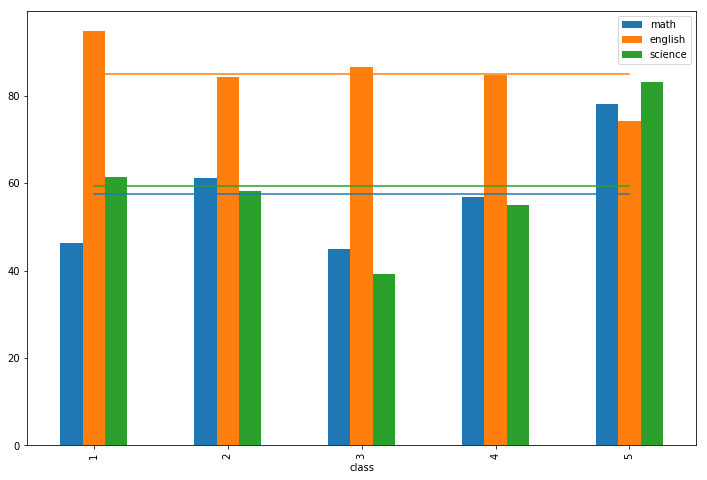

In [46]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
for subj in subj_mean.index.values:
    tmps = Series([subj_mean[subj]]*len(class_mean), index=range(5))
    ax.plot(tmps, label=subj)

class_mean.plot(kind="bar", ax=ax)

참고 : https://matplotlib.org/examples/color/named_colors.html

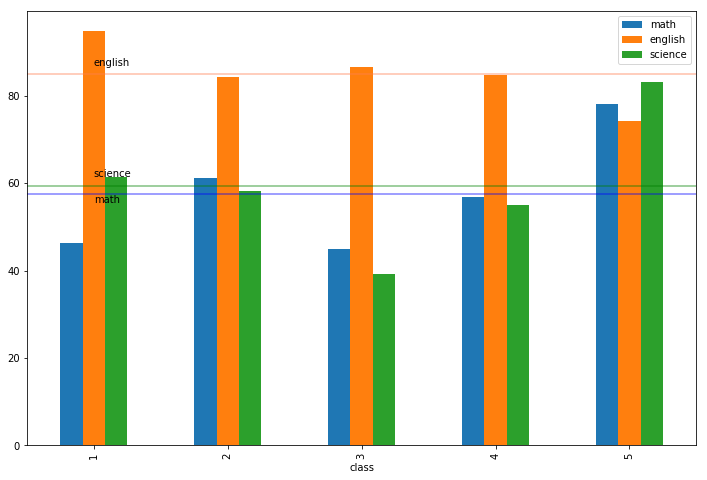

In [48]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
colors = ['b', 'coral', 'g']
for subj, c in zip(subj_mean.index.values, colors):
    ax.axhline(y=subj_mean[subj], label=subj, color=c, alpha=0.5)
    if subj == 'math': ax.text(0, subj_mean[subj]-2, subj)
    else: ax.text(0, subj_mean[subj]+2, subj)

class_mean.plot(kind="bar", ax=ax)

## 9장 실습
### 1. sex와 smoker 별로, 음식지불액 대비 팁의 비율을 구해보자.
tip_pct의 평균을 사용해볼까? 이 값은 우리가 생각하는 것과 전혀 다른 결과를 도출할 수 있다.

몇가지 이상치에 의해 왜곡된 결과를 줄 수 있다. 정확히는 음식지불액 합계 대비 팁의 합계를 구하는 것이 적절하다:
1. sex와 smoker를 그룹키로하여 그룹을 생성한다.
2. 각 그룹별로 bill과 tip의 합계를 구한다.
3. tip 합계를 bill 합계로 나눈다.
4. 막대 그래프를 그려본다.

In [2]:
tips = pd.read_csv('../examples/tips.csv')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [3]:
tips.time.value_counts()

Dinner    176
Lunch      68
Name: time, dtype: int64

In [4]:
tip_group = tips.groupby(['sex', 'smoker'])

In [5]:
tip_sum = tip_group[['total_bill', 'tip']].sum()
tip_sum

total_bill     tip
sex    smoker                    
Female No          977.68  149.77
       Yes         593.27   96.74
Male   No         1919.75  302.00
       Yes        1337.07  183.07

In [6]:
tip_rate = tip_sum.tip / tip_sum.total_bill
tip_rate

sex     smoker
Female  No        0.153189
        Yes       0.163062
Male    No        0.157312
        Yes       0.136919
dtype: float64

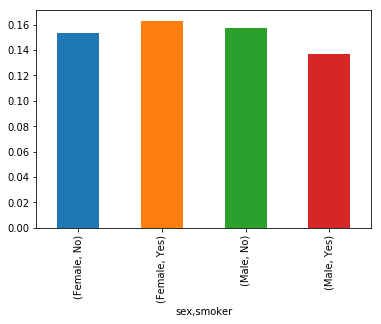

In [7]:
tip_rate.plot(kind='bar')

### 2. time 별로 bill의 min max mean와 tip의 min max mean을 구해보자.

In [8]:
tg = tips.groupby('time')

In [9]:
tg[['total_bill', 'tip']].agg(['min', 'max', 'mean'])

total_bill                     tip                
              min    max       mean   min   max      mean
time                                                     
Dinner       3.07  50.81  20.797159  1.00  10.0  3.102670
Lunch        7.51  43.11  17.168676  1.25   6.7  2.728088

In [10]:
tg[['total_bill', 'tip']].agg([min, 'max', 'mean'])

total_bill                     tip                
              min    max       mean   min   max      mean
time                                                     
Dinner       3.07  50.81  20.797159  1.00  10.0  3.102670
Lunch        7.51  43.11  17.168676  1.25   6.7  2.728088

### 3. time, sex별 건수와 평균 size를 구해보자.

In [11]:
tsg = tips.groupby(['time', 'sex'])

In [12]:
tsg['size'].size()

time    sex   
Dinner  Female     52
        Male      124
Lunch   Female     35
        Male       33
Name: size, dtype: int64

In [34]:
tsg['size'].agg('size')

time    sex   
Dinner  Female     52
        Male      124
Lunch   Female     35
        Male       33
Name: size, dtype: int64

In [35]:
tsg['size'].mean()

time    sex   
Dinner  Female    2.461538
        Male      2.701613
Lunch   Female    2.457143
        Male      2.363636
Name: size, dtype: float64

In [36]:
pd.concat([tsg['size'].size(), tsg['size'].mean()], axis=1)

size      size
time   sex                   
Dinner Female    52  2.461538
       Male     124  2.701613
Lunch  Female    35  2.457143
       Male      33  2.363636

In [37]:
pd.concat({'count':tsg['size'].size(), 'mean_size':tsg['size'].mean()}, axis=1)

count  mean_size
time   sex                     
Dinner Female     52   2.461538
       Male      124   2.701613
Lunch  Female     35   2.457143
       Male       33   2.363636

DataFrame의 병합 메소드들(min, max, mean, median, size 등)을 agg의 인자로 문자열로 전달한다.

In [43]:
tsg['size'].agg(['size', 'mean'])

size      mean
time   sex                   
Dinner Female    52  2.461538
       Male     124  2.701613
Lunch  Female    35  2.457143
       Male      33  2.363636

In [2]:
import re
import urllib.request

fileNum = 0
todayHumorUrl = 'http://www.todayhumor.co.kr/board/list.php?kind=total&table=total&page='

for postNo in range(2110, 2200):
    url = todayHumorUrl + str(postNo)
    f = urllib.request.urlopen(url)
    html = f.read()
    imageUrls = re.findall("http://humor.oceanmate.co.kr/fun_img/[^\"\s>]+", str(html))
    for url in imageUrls:
        contents = urllib.request.urlopen(url)
        fname = "C:\\p_temp\\" + str(fileNum) + '.jpg'
        file = open(fname, 'wb')
        file.write(contents.read())
        file.close()
        fileNum += 1

HTTPError: HTTP Error 403: Forbidden